In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import os
import re

import scipy as sc

################################################
# Load in Sample Size Data
################################################

base_path = "./dispersion_experiment/results/"
files = os.listdir(base_path)

file_dfs = []

file_expr = re.compile(r"^Power-.+_stamp(?P<stamp>[a-zA-Z0-9]+)_t(?P<t>\d+)_B(?P<B>\d+)_n(?P<n>\d+)_p(?P<p>\d+)_beta(?P<beta>\d+[.]\d+)_edist(?P<edist>\w+)_seed(?P<seed>\d+)\.csv")
for file in files:
    file_df = pd.read_csv(base_path + file, index_col = 0)
    file_data = re.match(file_expr, file).groupdict()
    file_df["edist"] = file_data["edist"]
    file_df["stamp"] = int(file_data["stamp"])
    file_df["t"] = int(file_data["t"])
    file_df["B"] = int(file_data["B"])
    file_df["n"] = int(file_data["n"])
    file_df["p"] = int(file_data["p"])
    file_df["beta"] = float(file_data["beta"])
    file_dfs.append(file_df)

dispersion_df = pd.concat(file_dfs, ignore_index = True)
del file_dfs


In [5]:
file_path = "./dispersion_experiment/Breusch-Pagan_t1000_stamp1732909147.770154_seed112920241000.csv"
bp_df = pd.read_csv(file_path, index_col = 0)
bp_df = bp_df.drop(["alpha", "p"], axis = 1)
bp_df = bp_df.rename({"power" : "BP-Power"}, axis = 1)

all_powers = dispersion_df.groupby(["n", "edist", "beta"])["dispersion-pval"].aggregate(lambda x: np.mean(x <= 0.05)).reset_index()
all_powers = all_powers.rename({ "dispersion-pval" : "PALMRT-Power"}, axis = 1)
all_powers = pd.merge(
    left = all_powers,
    right = bp_df,
    left_on = ["n", "edist", "beta"],
    right_on = ["n", "edist", "beta"],
)

all_powers

,n,edist,beta,PALMRT-Power,BP-Power
0,100,Cauchy,0.0,0.007,0.009
1,100,Cauchy,0.5,0.045,0.018
2,100,Cauchy,1.0,0.125,0.030
3,100,Cauchy,1.5,0.252,0.030
4,100,Cauchy,2.0,0.378,0.066
5,100,LogNormal,0.0,0.010,0.034
6,100,LogNormal,0.5,0.083,0.111
7,100,LogNormal,1.0,0.309,0.243
8,100,LogNormal,1.5,0.565,0.366
9,100,LogNormal,2.0,0.751,0.449


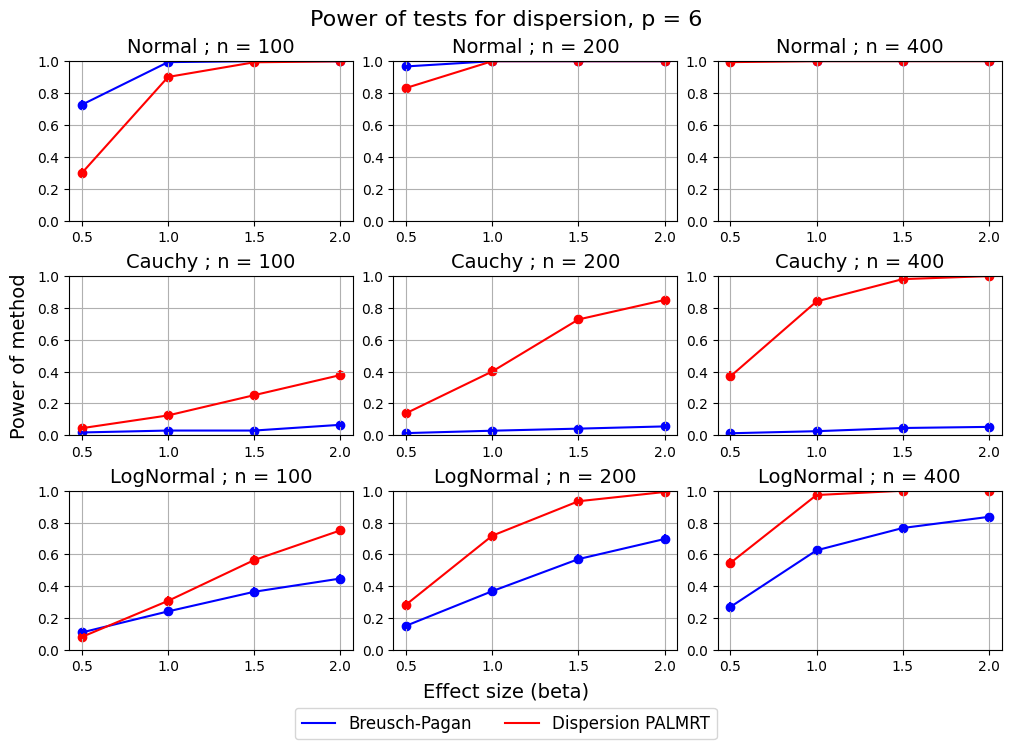

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
fig = plt.figure(layout="constrained", figsize = (10, 7))
axs = fig.subplots(nrows = 3, ncols = 3)

fig.supxlabel("Effect size (beta)", fontsize = 14)
fig.supylabel("Power of method", fontsize = 14)
fig.suptitle(f"Power of tests for dispersion, p = 6", fontsize = 16)

edists = ["Normal", "Cauchy", "LogNormal"]
ns = [100, 200, 400]
trials = 1000

def plot_errorbars_for_method_power_sample_size(ax, method_power, beta_values, color, offset):
    # First compute exact binomial intervals
    counts_for_method = method_power * trials
    lower_bounds = sc.stats.beta.ppf(0.025,
        counts_for_method,
        trials - counts_for_method + 1)
    lower_bounds[np.isnan(lower_bounds)] = 0.

    upper_bounds = sc.stats.beta.ppf(0.975,
        counts_for_method + 1,
        trials - counts_for_method)
    upper_bounds[np.isnan(upper_bounds)] = 1.

    # Plot the error bars using ax.errorbar method
    ax.errorbar(
        beta_values + offset,
        method_power,
        yerr = (method_power - lower_bounds, upper_bounds - method_power),
        xerr = None,
        color = color,
        ls = "none"
    )

offset = 0.
for i, edist in enumerate(edists):
    for j, n in enumerate(ns):
        edist_filter = all_powers["edist"] == edist
        n_filter = all_powers["n"] == n
        beta_filter = all_powers["beta"] > 0
        sub_df = all_powers[edist_filter & n_filter & beta_filter]

        axs[i, j].plot(sub_df["beta"] - offset, sub_df["BP-Power"], color = "blue", label = "BP")
        axs[i, j].scatter(sub_df["beta"] - offset, sub_df["BP-Power"], color = "blue")
        plot_errorbars_for_method_power_sample_size(
            axs[i, j],
            sub_df["BP-Power"],
            beta_values = sub_df["beta"],
            color = "blue",
            offset = -offset
        )

        axs[i, j].plot(sub_df["beta"] + offset, sub_df["PALMRT-Power"], color = "red", label = "PALMRT")
        axs[i, j].scatter(sub_df["beta"] + offset, sub_df["PALMRT-Power"], color = "red")
        plot_errorbars_for_method_power_sample_size(
            axs[i, j],
            sub_df["PALMRT-Power"],
            beta_values = sub_df["beta"],
            color = "red",
            offset = offset
        )

        axs[i, j].set_ylim((0, 1))
        axs[i, j].grid(True)

        axs[i, j].set_title(f"{edist} ; n = {n}", fontsize = 14)



handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, ["Breusch-Pagan", "Dispersion PALMRT"], ncols = 2, 
    loc = "lower center", bbox_to_anchor = (0.5, -0.06, 0., 0.), fontsize = 12)

plt.show()
fig.savefig(f"./images/5-dispersion_sim_power.eps", dpi = 800, bbox_inches = "tight")